In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np

Using TensorFlow backend.


In [2]:
MAX_WORDS = 10000
MAX_FEATURE_LEN = 1000

In [3]:
train_data = pd.read_csv('https://media.githubusercontent.com/media/mateusz-szczesny/fake-news-detector/master/Data/train.csv')

In [4]:
X_train, X_val, y_train, y_val = train_test_split(train_data.text, train_data.label, test_size=0.2, shuffle=False)

In [5]:
tokenizer = Tokenizer(num_words=MAX_WORDS)

tokenizer.fit_on_texts(X_train)
print(f'Znaleziono {len(tokenizer.word_index)} unikatowych tokenów.')

sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=MAX_FEATURE_LEN)
y_train = y_train

sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(sequences, maxlen=MAX_FEATURE_LEN)
y_val = y_val

print(f'Kształt tensora danych: {X_train.shape}')
print(f'Kształt tensora etykiet: {y_train.shape}')

Znaleziono 225549 unikatowych tokenów.
Kształt tensora danych: (18676, 1000)
Kształt tensora etykiet: (18676,)


In [6]:
EMBEDDING_DIM = 100
embedding_index = {}

with open('../GloVe/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if i < MAX_WORDS:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print('Glove załadowane!')

Glove załadowane!


In [8]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, GlobalMaxPool1D

model = Sequential()

model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_FEATURE_LEN, weights=[embedding_matrix], trainable=True))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc',])

In [9]:
checkpoint = ModelCheckpoint(
    'best.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=4, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001, 
    cooldown=0, 
    min_lr=0
)

history = model.fit(X_train, y_train, epochs=20, batch_size=1024, validation_data=(X_val, y_val), callbacks=[checkpoint, reduce_lr])

Train on 18676 samples, validate on 4670 samples
Epoch 1/20


ResourceExhaustedError:  OOM when allocating tensor with shape[1024,1000,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node embedding_2/embedding_lookup (defined at C:\Users\Mateusz\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\backend\tensorflow_backend.py:3007) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_777]

Function call stack:
keras_scratch_graph


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    'best.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='max'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

history = model.fit(x_train, y_train, epochs=20, batch_size=1024, validation_data=(x_val, y_val), callbacks=[checkpoint, reduce_lr])

Train on 18039 samples, validate on 4808 samples
Epoch 1/20
18039/18039 [==============================] - 2s 103us/step - loss: 0.8277 - acc: 0.5456 - val_loss: 0.6360 - val_acc: 0.6252

Epoch 00001: val_acc improved from -inf to 0.62521, saving model to best.h5
Epoch 2/20
18039/18039 [==============================] - 2s 87us/step - loss: 0.6329 - acc: 0.6393 - val_loss: 0.6253 - val_acc: 0.6639

Epoch 00002: val_acc improved from 0.62521 to 0.66389, saving model to best.h5
Epoch 3/20
18039/18039 [==============================] - 2s 86us/step - loss: 0.6134 - acc: 0.6493 - val_loss: 0.5997 - val_acc: 0.6799

Epoch 00003: val_acc improved from 0.66389 to 0.67991, saving model to best.h5
Epoch 4/20
18039/18039 [==============================] - 2s 86us/step - loss: 0.6033 - acc: 0.6595 - val_loss: 0.6286 - val_acc: 0.6169

Epoch 00004: val_acc did not improve from 0.67991
Epoch 5/20
18039/18039 [==============================] - 2s 87us/step - loss: 0.6048 - acc: 0.6595 - val_loss: 0.

In [ ]:
model.save_weights('pre_trained_model.h5')

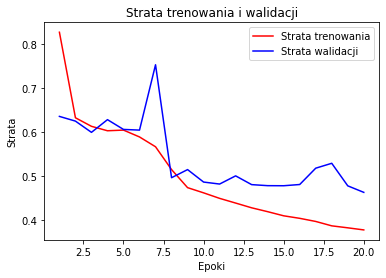

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')

plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

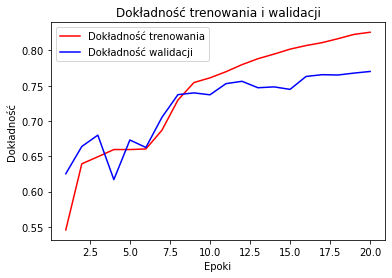

In [ ]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'r', label='Dokładność trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokładność walidacji')

plt.title('Dokładność trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()

plt.show()

In [ ]:
test_data = pd.read_csv('https://media.githubusercontent.com/media/mateusz-szczesny/fake-news-detector/master/Data/test.csv')
sequences = tokenizer.texts_to_sequences(test_data.text)
X_test = pad_sequences(sequences, maxlen=MAX_FEATURE_LEN)
y_test = test_data.label

model.evaluate(X_test, y_test)

3089/3089 [==============================] - 1s 211us/step


[0.4660237384540975, 0.7701521515846252]